In [1]:
library(Seurat)

In [3]:
c.data <- Read10X(data.dir = "/extra/schule/ctr/")
# Initialize the Seurat object with the raw (non-normalized data).
sc <- CreateSeuratObject(
    counts = c.data, 
    project = "control", 
    min.cells = 3,
    min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [4]:
sc[["percent.mt"]] <- PercentageFeatureSet(object = sc, pattern = "^MT-")

In [6]:
head(sc[["percent.mt"]])

,percent.mt
AAACCTGCACGCTTTC,2.9947917
AAACCTGGTGAAATCA,3.2088276
AAACCTGGTTACAGAA,4.2695010
AAACCTGGTTCCATGA,0.2125936
AAACCTGTCACAGGCC,6.1853058
AAACCTGTCCCATTTA,4.3614262


In [33]:
dim(sc)

[1] 18640  3709

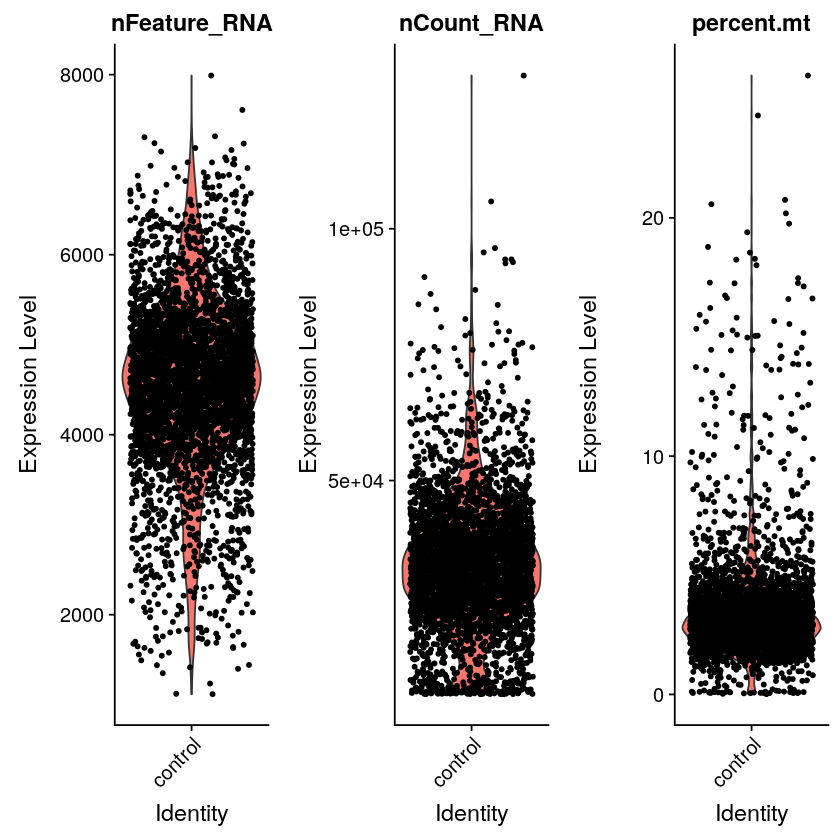

In [9]:
VlnPlot(object = sc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [22]:
plot1 <- FeatureScatter(object = sc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(object = sc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

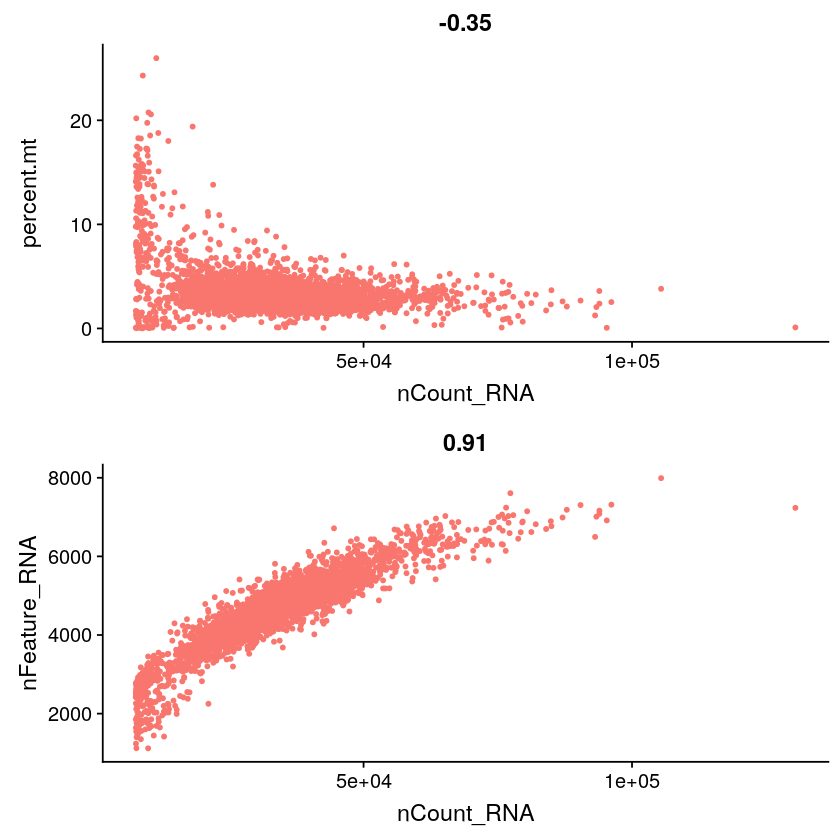

In [25]:
CombinePlots(plots = list(plot1, plot2), legend="none", ncol=1)

A few cells with low counts and high mitochondrial counts that we wish to filter out. Let's get rid of any cells with a MT count greater than 10, features > 2000, and features < 6000, counts > 7e4


In [30]:
sc.sub <- subset(x=sc, subset = nFeature_RNA > 2000 & nFeature_RNA < 7000 & 
             percent.mt <= 7 & 
             nCount_RNA < 7e4 & nCount_RNA > 3e3)

In [31]:
plot1 <- FeatureScatter(object = sc.sub, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(object = sc.sub, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

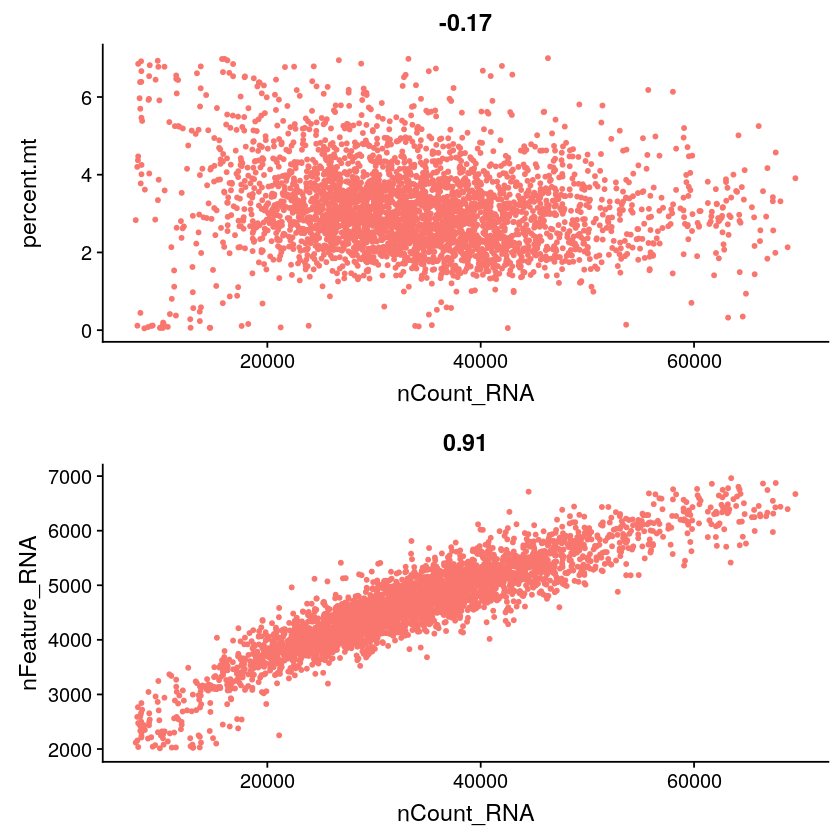

In [32]:
CombinePlots(plots = list(plot1, plot2), legend="none", ncol=1)

In [40]:
data.frame(orig=dim(sc), sub=dim(sc.sub), row.names=c("Genes", "Cells"))

,orig,sub
Genes,18640,18640
Cells,3709,3448


We seem to have less impact from MT genes now, and less cell outliers. Filtering has not removed too many cells from the analysis.

This seems good enough for now, let's normalize and see how things cluster.

# Normalisation

In [41]:
# These are actually defaults.
sc <- NormalizeData(object= sc.sub, normalization.method = "LogNormalize", scale.factor=10000)

In [42]:
sc <- FindVariableFeatures(object = sc, selection.method = "vst", nfeatures = 2000)

In [49]:
# Most variable genes
topN <- head(x = VariableFeatures(object = sc), 30)
topN

[1] "MSMP"      "FST"       "HIST1H4C"  "BIRC5"     "UBE2C"     "GDF15"    
 [7] "REG4"      "AREG"      "TUBA1B"    "UTS2"      "PTTG1"     "HSPA5"    
[13] "HMGB2"     "DDIT3"     "UBE2S"     "PAGE5"     "PLAU"      "TNFRSF12A"
[19] "ERRFI1"    "TOP2A"     "FTH1"      "CENPA"     "CTAG2"     "IL13RA2"  
[25] "OASL"      "CKS2"      "FOSL1"     "HMGA1"     "TSPAN19"   "ATF3"

In [50]:
plot1 <- VariableFeaturePlot(object = sc)
plot2 <- LabelPoints(plot = plot1, points = topN, repel = TRUE)

When using repel, set xnudge and ynudge to 0 for optimal results


Warning message:
“Transformation introduced infinite values in continuous x-axis”

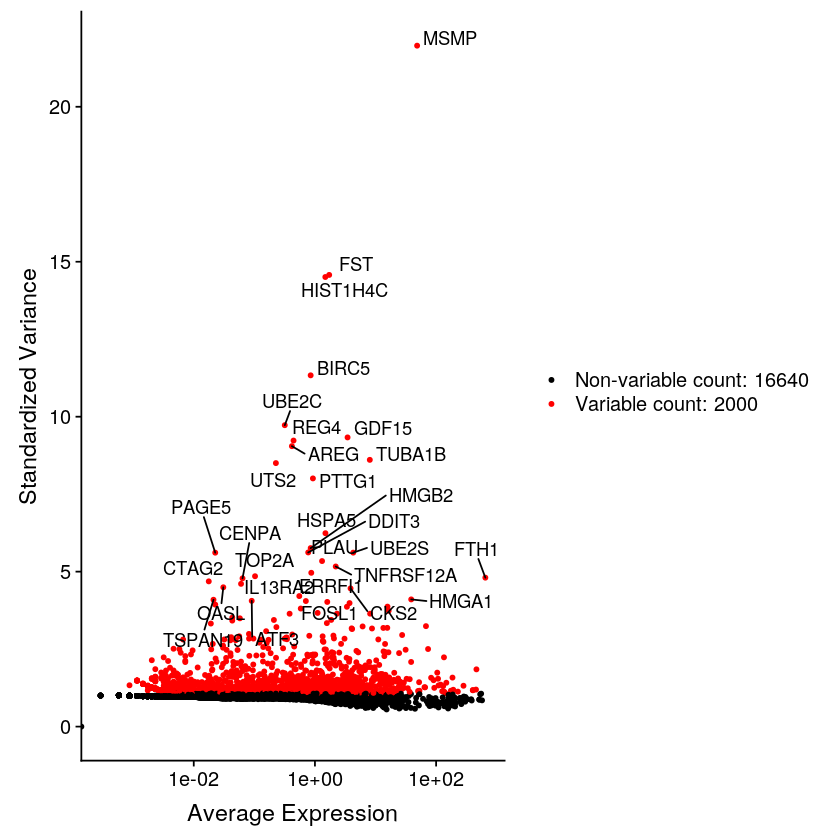

In [51]:
plot2

# Scaling

In [52]:
# Performed prior to dim reduction so that only variance is used for dimred and not total counts or other unwanted var

In [54]:
all.genes <- rownames(x = sc)

In [55]:
sc <- ScaleData(object = sc, features = all.genes)

Centering and scaling data matrix


Removing cell-cycle variation may be required, but removing mitochondrial contamination is likely not neccesary since we have already filtered out the cells with more than 7% MT contamination.

# Dimensional Reduction

In [56]:
# PCA
sc <- RunPCA(object = sc, features = VariableFeatures(object = sc))

PC_ 1 
Positive:  HSP90AA1, ENO1, RAN, PRDX1, TPI1, NME1, PFDN2, ANXA2, HN1, PSMA7 
	   PARK7, MGST1, CD59, ETFB, FABP5, PRDX2, CD63, LDHA, COX5B, GADD45GIP1 
	   S100A11, NDUFB9, RBM8A, PSME2, PKM, TXN, CFL1, PGK1, CD320, TUBA1B 
Negative:  GNB2L1, EEF1A1, RPL12, RPS4X, RPS6, RPL10, RPL7, RPS3A, RPL39, SLC25A6 
	   RPL4, RPL26, CREB3L1, RPSA, CDKN2C, RPS24, TMEM158, SUCO, ZNF581, CTD-2589M5.4 
	   TCF4, PABPC1, LDOC1, FAM65B, BTG1, H1F0, LMO4, CD24, SPINK5, SLC12A2 
PC_ 2 
Positive:  AGR2, GRN, PPIB, TFPI, TIMP1, HLA-A, TMEM59, B2M, CD63, CLU 
	   KRT18, HSP90B1, LAPTM4A, SSR4, LRPAP1, PSMB1, ITM2B, MAGED2, TUBA1A, HSPA5 
	   MDH1, ATP5B, MAGED1, LGALS3, RPN2, NDUFS2, SPCS2, DAD1, MGST3, BSG 
Negative:  PRELID1, HMGA1, LSM4, YBX1, BIRC5, STRA13, PRSS3, COTL1, PPDPF, PPP1R14B 
	   FTL, GPX4, S100A16, PHF19, FTH1, CDCA4, CKS1B, GLRX5, KIAA0101, TMSB10 
	   SRM, PTTG1, RPSA, RPL4, ODC1, TROAP, SH3BGRL3, EIF4EBP1, HPCAL1, HMGN2 
PC_ 3 
Positive:  TOP2A, HMGB2, UBE2C, NUSAP1, CDK1, BIRC5, 

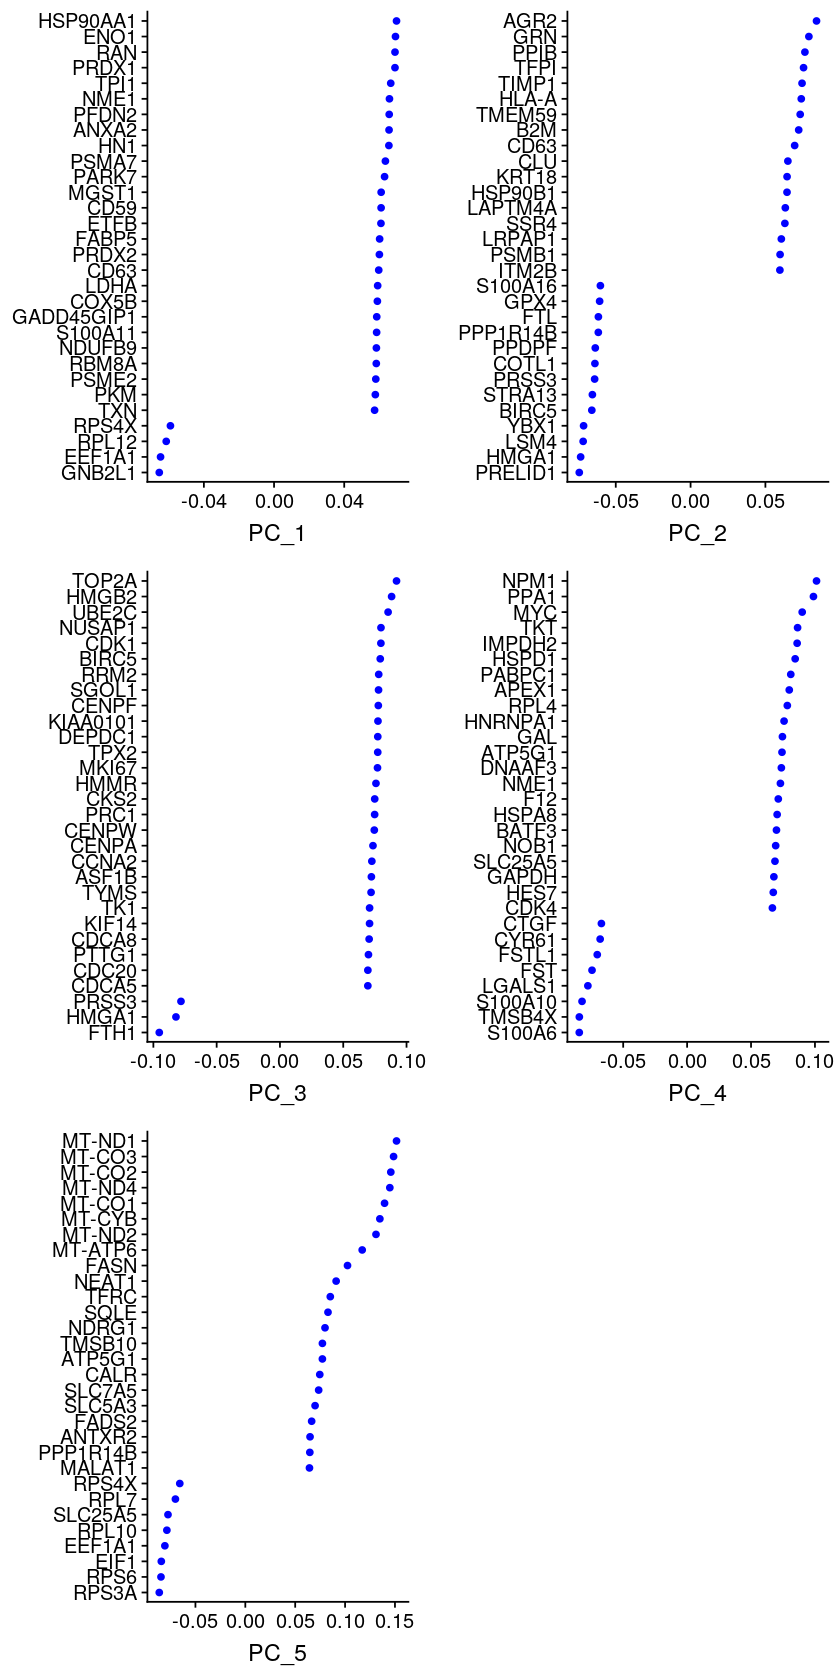

In [65]:
options(repr.plot.height = 14)
VizDimLoadings(object = sc, dims=1:5, reductions = "pca")

In [78]:
plist <- list(
    DimPlot(object = sc, reduction = "pca", dims=c(1,2)),
    DimPlot(object = sc, reduction = "pca", dims=c(1,3)),
    DimPlot(object = sc, reduction = "pca", dims=c(1,4)),
    DimPlot(object = sc, reduction = "pca", dims=c(1,5)),
    DimPlot(object = sc, reduction = "pca", dims=c(2,3)),
    DimPlot(object = sc, reduction = "pca", dims=c(2,4)),
    DimPlot(object = sc, reduction = "pca", dims=c(2,5)),
    DimPlot(object = sc, reduction = "pca", dims=c(3,4)),
    DimPlot(object = sc, reduction = "pca", dims=c(3,5)),
    DimPlot(object = sc, reduction = "pca", dims=c(4,5)))

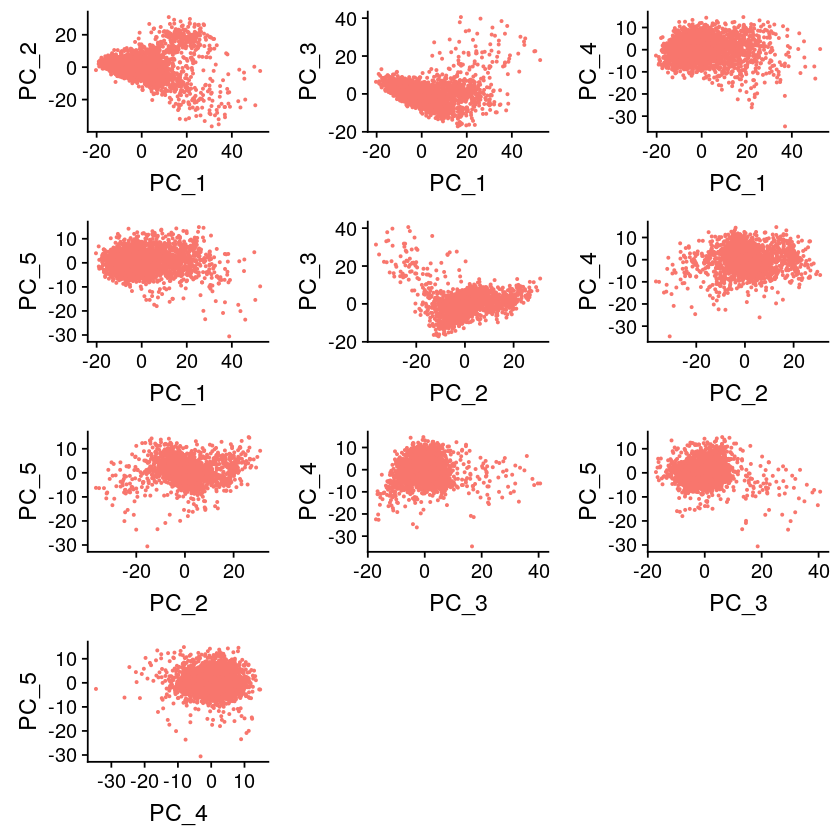

In [80]:
options(repr.plot.height = 7)
CombinePlots(plist, ncol=3, legend="none")

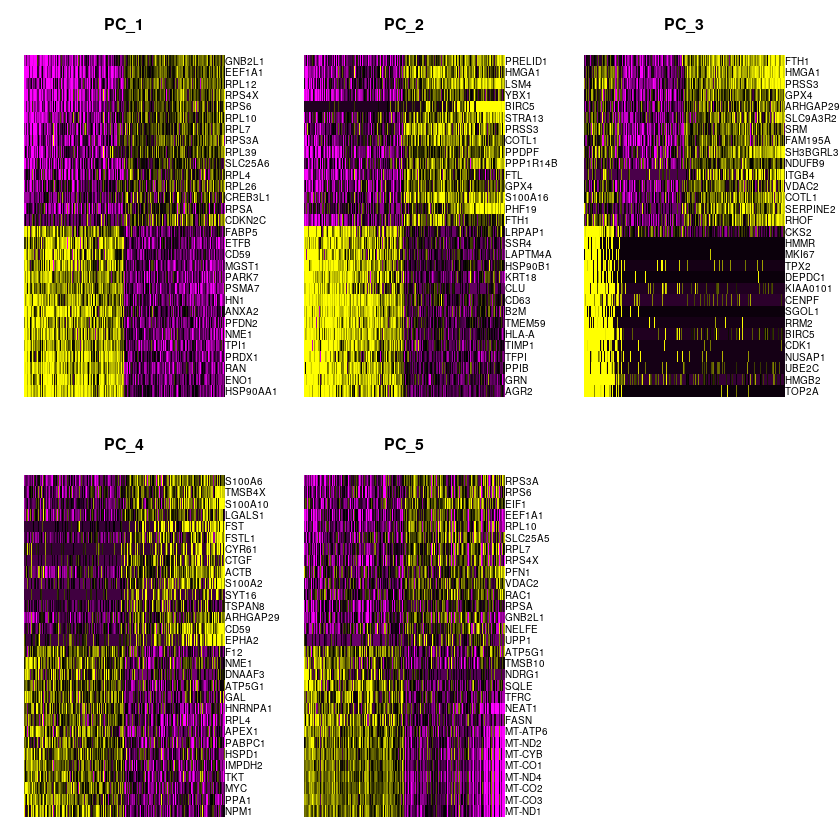

In [81]:
DimHeatmap(object = sc, dims = 1:5, cells=500, balanced = TRUE)

# Reducing the Dimensionality of the Set

Determining number of PC's to keep, we use Jackstraw Plot

In [92]:
sc <- JackStraw(object=sc, num.replicate = 100)

In [93]:
sc <- ScoreJackStraw(object = sc, dims = 1:20)

Warning message:
“Removed 21002 rows containing missing values (geom_point).”

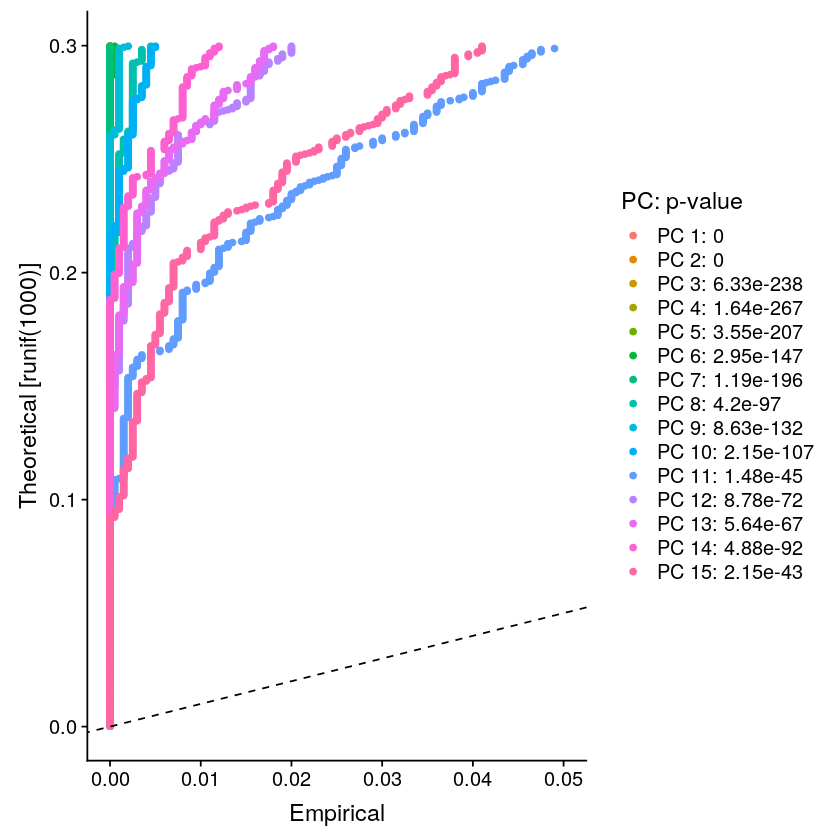

In [97]:
JackStrawPlot(object = sc, dims = 1:15, xmax = 0.05)

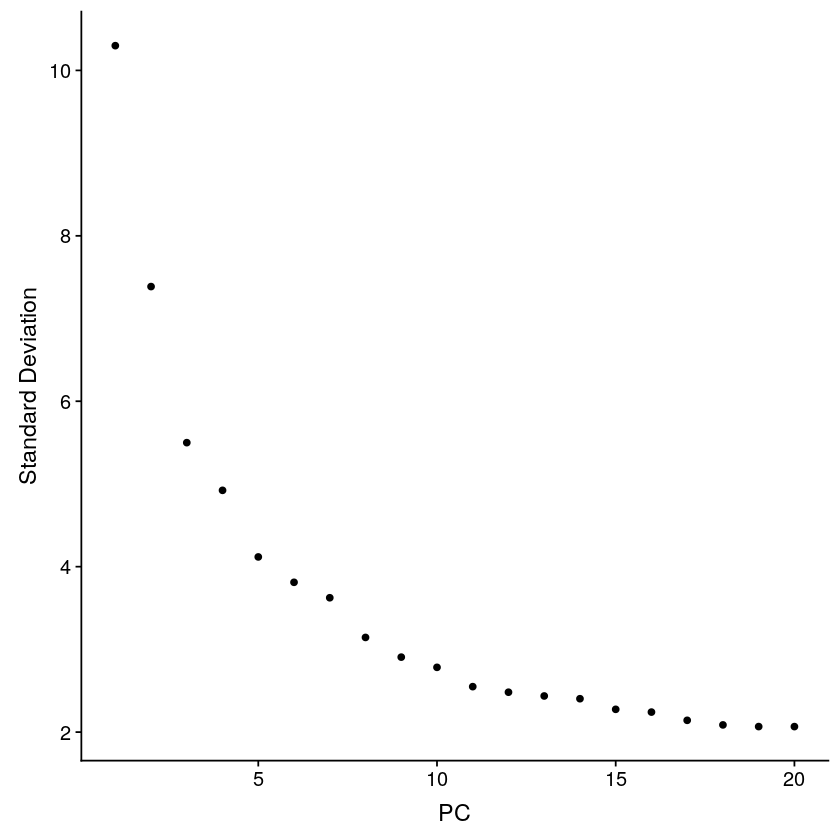

In [98]:
ElbowPlot(object = sc)

# Initial Seurat with defaults

In [14]:
sc <- CreateSeuratObject(raw.data = c.mat, project="control", 
                         min.cells=3, 
                         min.features=200)

In [15]:
sc <- FilterCells(
    object = sc, 
    subset.names = c("nUMI"), 
    high.thresholds = c(2e7),
    low.thresholds = c(3000)
)

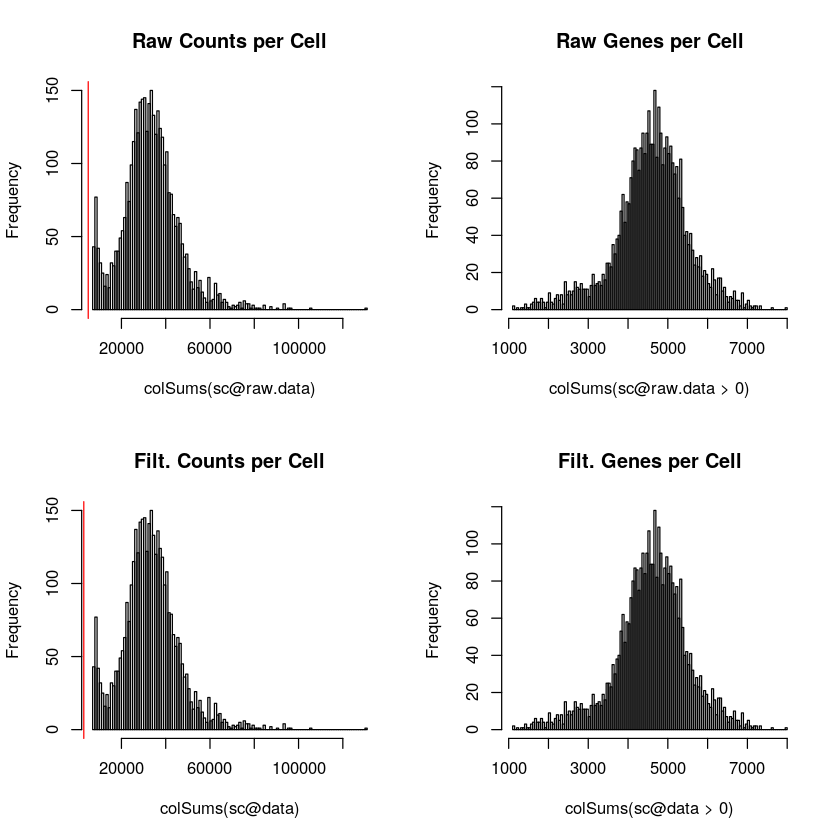

In [17]:
par(mfrow=c(2,2))
hist(colSums(sc@raw.data), breaks = 100, main = "Raw Counts per Cell")
abline(v=5000, col = 'red')
hist(colSums(sc@raw.data > 0), breaks = 100, main = "Raw Genes per Cell")

hist(colSums(sc@data), breaks = 100, main = "Filt. Counts per Cell")
abline(v=3000, col = 'red')
hist(colSums(sc@data > 0), breaks = 100, main = "Filt. Genes per Cell")

In [12]:
sc <- NormalizeData(object = sc)

In [13]:
sc <- FindVariableFeatures(object = sc)

ERROR: Error in FindVariableFeatures(object = sc): could not find function "FindVariableFeatures"
